In [1]:
import pandas as pd
from pathlib import Path

import os, sys
sys.path.append(os.path.abspath('..'))
from python_scripts.anomaly_detection import (
    detect_eve_anom,
    apply_clinical_flags,
    AnomalyConf,
    ThreadsConf,
)

## Load Data

In [2]:
event_anom_df = pd.read_csv('../data/metrics/events.csv')

td_anom_df = pd.read_csv('../data/metrics/patient_metrics.csv')

## Event Deviations Detection
* Detecting unsual events during walking session.
* This is to detect abnormal walking pattern compared with their own pattern.

In [3]:
event_anom_cfg = AnomalyConf(
    features=(
        "contact_time_sec",
        "pti",
        "propulsion_index",
        "peak_load",
        "mean_load",
    ),
    z_threshold=3.5,
    eve_per_patient=3,
    top_k_reasons=3,
)

event_with_anom = detect_eve_anom(
    event_anom_df,
    config=event_anom_cfg
)

event_with_anom.sort_values(
    "anomaly_score",
    ascending=False
).head()

,patient_id,segment_id,event_id,start_time,end_time,contact_time_sec,mean_load,peak_load,load_var,pti,...,has_patient_baseline,is_segment_anomaly,anomaly_reasons,pti_lo,pti_hi,pti_direction,mean_load_lo,mean_load_hi,mean_load_direction,anom_reason_exp
5,47,0,6,2023-11-08 18:19:37.171,2023-11-08 18:19:38.656,1.485,150.616443,161.472849,66.120594,159.216210,...,False,False,,157.077739,162.791073,within NORMAL range,150.846648,162.580049,LOWER,
95,424,2,0,2024-07-22 17:07:37.544,2024-07-22 17:07:38.211,0.667,3.888361,6.813126,10.387038,1.884447,...,False,False,,7.307531,53.506060,LOWER,11.460767,43.852340,LOWER,
12,85,0,6,2023-12-21 13:19:17.597,2023-12-21 13:19:18.994,1.397,173.071873,187.711599,79.035718,172.693507,...,False,False,,124.149263,160.556316,HIGHER,173.532615,188.543432,LOWER,
14,85,0,10,2023-12-21 13:19:25.407,2023-12-21 13:19:26.465,1.058,193.537971,200.163515,57.453241,132.236206,...,False,False,,124.149263,160.556316,within NORMAL range,173.532615,188.543432,HIGHER,
3,47,0,4,2023-11-08 18:19:34.384,2023-11-08 18:19:35.778,1.394,165.283193,181.572656,149.077954,163.684789,...,False,False,,157.077739,162.791073,HIGHER,150.846648,162.580049,HIGHER,


## Save Data

In [4]:
out = Path('../data/anomaly')
out.mkdir(parents=True, exist_ok=True)

In [5]:
event_with_anom.to_csv(out / 'event_anomalies.csv', index=False)
print('Saved event_anomalies.csv')

Saved event_anomalies.csv


## Visualisation

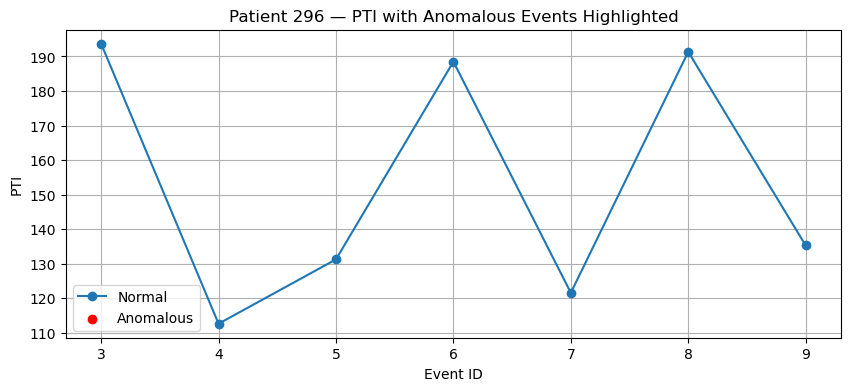

In [8]:
import matplotlib.pyplot as plt


anom = pd.read_csv("../data/anomaly/event_anomalies.csv")
pid = 296
ev = anom[anom["patient_id"] == pid].copy()


plt.figure(figsize=(10,4))

normal = ev[~ev["is_segment_anomaly"]]
bad = ev[ev["is_segment_anomaly"]]

plt.plot(normal["event_id"], normal["pti"], marker="o", label="Normal")
plt.scatter(bad["event_id"], bad["pti"], color="red", label="Anomalous")

plt.title(f"Patient {pid} — PTI with Anomalous Events Highlighted")
plt.xlabel("Event ID")
plt.ylabel("PTI")
plt.legend()
plt.grid(True)

out_path = f"../figures/id_{pid}_anomalous_events.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

## Threshold-based clinical flags
* These threshold anomalies are detected whether a metric is outside of a clinical accepted thresholds (normal range) or within.
* These thresholds are not assumptions but referenced by publised literatures.

In [7]:
clinical_cfg = ThreadsConf(
    thresholds={
        'mean_cadence_low': 40.0,
        'mean_cadence_high': 150.0,
        'step_interval_cv_high': 0.50,
        'temp_mean_low': 25.0,
        'mean_contact_low': 0.40,
        'mean_contact_high': 1.30,
        'mean_stance_pct_low': 55.0,
        'mean_stance_pct_high': 65.0,
    }
)

metric_flags = apply_clinical_flags(
    td_anom_df,
    config=clinical_cfg
)

metric_flags[metric_flags["clinical_flag"]].head()

metric_flags.to_csv(out / 'metric_flags.csv', index=False)
print('Saved segment_flags.csv')
metric_flags.head()

Saved segment_flags.csv


,patient_id,total_steps,total_walk_time_sec,mean_cadence,cadence_var,mean_stance_pct,step_interval_mean,step_interval_cv,mean_contact,contact_var,mean_peak_load,max_peak_load,mean_temp,max_temp,segment_id,clinical_reasons,clinical_flag
0,85,4,9.945,24.132730,NaN,51.873522,2.962333,1.010232,1.152500,NaN,200.163515,200.163515,31.723958,34,85,mean_cadence<40; step_interval_cv>0.5; mean_st...,True
1,296,7,8.482,49.516623,NaN,114.668110,1.232833,0.173833,1.211714,NaN,205.996461,205.996461,29.500000,30,296,mean_stance_pct>65%,True
2,350,47,138.031,20.430193,NaN,42.100409,2.970022,1.710526,1.223787,NaN,116.376378,116.376378,31.751773,33,350,mean_cadence<40; step_interval_cv>0.5; mean_st...,True
3,392,3,152.724,1.178597,NaN,2.417473,75.657500,1.395615,1.219333,NaN,41.043988,41.043988,26.854167,35,392,mean_cadence<40; step_interval_cv>0.5; mean_st...,True
4,419,3,7.058,25.502975,NaN,54.337309,3.101000,0.907541,1.123333,NaN,45.610173,45.610173,27.583333,36,419,mean_cadence<40; step_interval_cv>0.5; mean_st...,True


## Visualisation

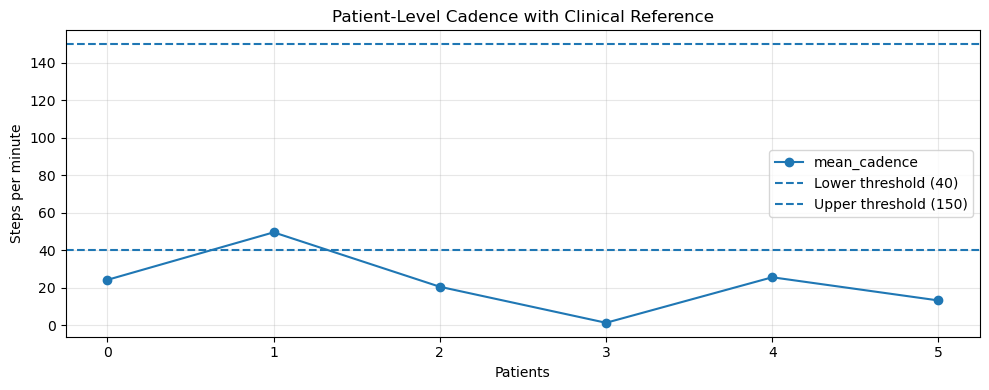

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../data/anomaly/metric_flags.csv")

def plot_metric_with_clinical_thresholds(
    df,
    y_col,
    lower_thresh=None,
    upper_thresh=None,
    title=None,
    y_label=None
):
    plt.figure(figsize=(10, 4))

    # Use row index as x-axis
    x = df.index

    plt.plot(x, df[y_col], marker="o", linewidth=1.5, label=y_col)

    if lower_thresh is not None:
        plt.axhline(
            lower_thresh,
            linestyle="--",
            linewidth=1.5,
            label=f"Lower threshold ({lower_thresh})"
        )

    if upper_thresh is not None:
        plt.axhline(
            upper_thresh,
            linestyle="--",
            linewidth=1.5,
            label=f"Upper threshold ({upper_thresh})"
        )

    plt.title(title or f"{y_col} with Clinical Thresholds")
    plt.xlabel("Patients")
    plt.ylabel(y_label or y_col)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_metric_with_clinical_thresholds(
    df,
    y_col="mean_cadence",
    lower_thresh=40,
    upper_thresh=150,
    title="Patient-Level Cadence with Clinical Reference",
    y_label="Steps per minute"
)

out_path = f"../figures/cadence_thredsholds_anomalies.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()